1. Deal with missing values and filling appropriately
2. Exploratory Data Analysis
3. Predictive Model - predicting amount of people vaccinated for the next 7 days

In [ ]:
#importing libraries
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
#scipy is a maths library
import scipy
#warnings allows you to program warning messsages
import warnings
import plotly.express as px
from itertools import product
import statsmodels.api as sm
import datetime
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [ ]:
#uploading country_vaccinations.csv file
from google.colab import files
uploaded = files.upload()

Saving country_vaccinations.csv to country_vaccinations (1).csv


In [ ]:
#loading the data into a dataframe
data = pd.read_csv('country_vaccinations.csv')

In [ ]:
#ensuring the data is loaded in correctly
data

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Algeria,DZA,2021-01-29,0.0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,Sputnik V,Ministry of Health,https://www.aps.dz/regions/116777-blida-covid-...
1,Algeria,DZA,2021-01-30,30.0,NaN,NaN,30.0,30.0,0.00,NaN,NaN,1.0,Sputnik V,Ministry of Health,https://www.aps.dz/regions/116777-blida-covid-...
2,Argentina,ARG,2020-12-29,700.0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,Sputnik V,Ministry of Health,http://datos.salud.gob.ar/dataset/vacunas-cont...
3,Argentina,ARG,2020-12-30,NaN,NaN,NaN,NaN,15656.0,NaN,NaN,NaN,346.0,Sputnik V,Ministry of Health,http://datos.salud.gob.ar/dataset/vacunas-cont...
4,Argentina,ARG,2020-12-31,32013.0,NaN,NaN,NaN,15656.0,0.07,NaN,NaN,346.0,Sputnik V,Ministry of Health,http://datos.salud.gob.ar/dataset/vacunas-cont...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,Wales,NaN,2021-01-27,336745.0,336071.0,674.0,23801.0,20845.0,10.68,10.66,0.02,6611.0,"Oxford/AstraZeneca, Pfizer/BioNTech",Government of the United Kingdom,https://coronavirus.data.gov.uk/details/health...
1930,Wales,NaN,2021-01-28,362970.0,362253.0,717.0,26225.0,21463.0,11.51,11.49,0.02,6807.0,"Oxford/AstraZeneca, Pfizer/BioNTech",Government of the United Kingdom,https://coronavirus.data.gov.uk/details/health...
1931,Wales,NaN,2021-01-29,378950.0,378200.0,750.0,15980.0,19705.0,12.02,12.00,0.02,6250.0,"Oxford/AstraZeneca, Pfizer/BioNTech",Government of the United Kingdom,https://coronavirus.data.gov.uk/details/health...
1932,Wales,NaN,2021-01-30,404249.0,403463.0,786.0,25299.0,19885.0,12.82,12.80,0.02,6307.0,"Oxford/AstraZeneca, Pfizer/BioNTech",Government of the United Kingdom,https://coronavirus.data.gov.uk/details/health...


In [ ]:
#checking the shape of the data
data.shape

(1934, 15)

In [ ]:
#check for missing data
data.isna().sum()

country                                   0
iso_code                                202
date                                      0
total_vaccinations                      656
people_vaccinated                       930
people_fully_vaccinated                1413
daily_vaccinations_raw                  889
daily_vaccinations                       71
total_vaccinations_per_hundred          656
people_vaccinated_per_hundred           930
people_fully_vaccinated_per_hundred    1413
daily_vaccinations_per_million           71
vaccines                                  0
source_name                               0
source_website                            0
dtype: int64

As we can see above there is a lot of missing data. 
First we will drop total_vaccinations as without any values this raw data doesn't make much sense

In [ ]:
data = data.drop(data[data.total_vaccinations.isna()].index)

In [ ]:
data.isna().sum()

country                                  0
iso_code                               102
date                                     0
total_vaccinations                       0
people_vaccinated                      291
people_fully_vaccinated                760
daily_vaccinations_raw                 233
daily_vaccinations                      67
total_vaccinations_per_hundred           0
people_vaccinated_per_hundred          291
people_fully_vaccinated_per_hundred    760
daily_vaccinations_per_million          67
vaccines                                 0
source_name                              0
source_website                           0
dtype: int64

In [ ]:
#checking people_vaccinated 
check_data = data.drop(data[data.people_vaccinated.isna()].index)

In [ ]:
check_data.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
24,Argentina,ARG,2021-01-20,247933.0,243539.0,4394.0,NaN,11586.0,0.55,0.54,0.01,256.0,Sputnik V,Ministry of Health,http://datos.salud.gob.ar/dataset/vacunas-cont...
25,Argentina,ARG,2021-01-21,265724.0,249372.0,16352.0,17791.0,11704.0,0.59,0.55,0.04,259.0,Sputnik V,Ministry of Health,http://datos.salud.gob.ar/dataset/vacunas-cont...
26,Argentina,ARG,2021-01-22,279602.0,254456.0,25146.0,13878.0,11263.0,0.62,0.56,0.06,249.0,Sputnik V,Ministry of Health,http://datos.salud.gob.ar/dataset/vacunas-cont...
27,Argentina,ARG,2021-01-23,288064.0,258876.0,29188.0,8462.0,11124.0,0.64,0.57,0.06,246.0,Sputnik V,Ministry of Health,http://datos.salud.gob.ar/dataset/vacunas-cont...
28,Argentina,ARG,2021-01-24,292023.0,260036.0,31987.0,3959.0,10342.0,0.65,0.58,0.07,229.0,Sputnik V,Ministry of Health,http://datos.salud.gob.ar/dataset/vacunas-cont...


It can be seen from the above data that , that the values of total_vaccinations and people_vaccinated are mostly the same. This is also the case for total_vaccinations_per_hundred and people_vaccinated_per_hundred. We will now check the correlation to see if this is the case.

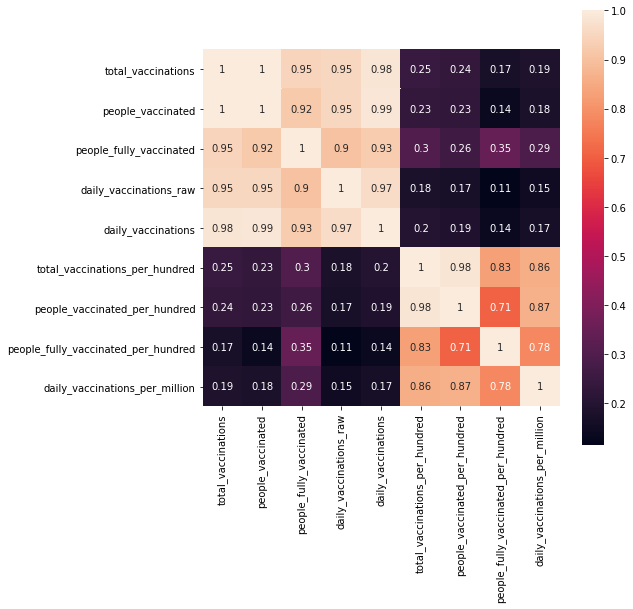

In [ ]:
#heatmap plots data as a color-encoded matrix 
#.corr() is used to find the pairwaise correlation of all columns in the dataframe - NA values are excluded
plt.subplots(figsize=(8,8))
sns.heatmap(check_data.corr(), annot=True, square=True)
plt.show()

The heatmap shows that these features have the most ideal correlations.

# people_vaccinated and people_vaccinated per_hundred
people_vaccinated and people_vaccinated_per_hundred greatly correlates with total_vaccinations and total_vaccinations_per_hundred. We will check this hypothesis that these columns and distributions are the same. We will use the Mann-Whitney U test for this goal. In statistics, the Mann–Whitney U test is a nonparametric test of the null hypothesis that, for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X.

In [ ]:
scipy.stats.mannwhitneyu(check_data.total_vaccinations, check_data.people_vaccinated)

MannwhitneyuResult(statistic=479337.5, pvalue=0.2703415212250936)

In [ ]:
scipy.stats.mannwhitneyu(check_data.total_vaccinations_per_hundred, check_data.people_vaccinated_per_hundred)

MannwhitneyuResult(statistic=475851.5, pvalue=0.1875120988854057)

The p-value in both instances is much higher than 0.05, which means we cannot reject our hypothesis. Thus, we will fill the missing values with the difference's of these column's mean values. 

In [ ]:
diff = check_data.total_vaccinations.mean() - check_data.people_vaccinated.mean()
diff_per_hundred = check_data.total_vaccinations_per_hundred.mean() - check_data.people_vaccinated_per_hundred.mean()

data.people_vaccinated = data.people_vaccinated.fillna(data.total_vaccinations - diff)
data.people_vaccinated_per_hundred = data.people_vaccinated_per_hundred.fillna(data.total_vaccinations_per_hundred - diff_per_hundred)

In [ ]:
#checking if these null values are now ammended
data.isna().sum()

country                                  0
iso_code                               102
date                                     0
total_vaccinations                       0
people_vaccinated                        0
people_fully_vaccinated                760
daily_vaccinations_raw                 233
daily_vaccinations                      67
total_vaccinations_per_hundred           0
people_vaccinated_per_hundred            0
people_fully_vaccinated_per_hundred    760
daily_vaccinations_per_million          67
vaccines                                 0
source_name                              0
source_website                           0
dtype: int64

# daily_vaccinations and daily_vaccinations_per_million


daily_vaccinations and daily_vaccinations_per_million greatly correlates with people_vaccinated and people_vaccinated_per_hundred

In [ ]:
#checking the above hypothesis - i.e that these columns distributions are the same
scipy.stats.mannwhitneyu(check_data.people_vaccinated, check_data.daily_vaccinations)

MannwhitneyuResult(statistic=221218.0, pvalue=3.508994337909303e-98)

In [ ]:
scipy.stats.mannwhitneyu(check_data.people_vaccinated_per_hundred, check_data.daily_vaccinations_per_million)

MannwhitneyuResult(statistic=7324.5, pvalue=0.0)

The above p-values are much less than 0.05 so we will reject our hypothesis. Thus, we will fill in the missing values with zeroes

In [ ]:
data.daily_vaccinations = data.daily_vaccinations.fillna(0)
data.daily_vaccinations_per_million = data.daily_vaccinations_per_million.fillna(0)

In [ ]:
#checking the dataframe for null values again
data.isna().sum()

country                                  0
iso_code                               102
date                                     0
total_vaccinations                       0
people_vaccinated                        0
people_fully_vaccinated                760
daily_vaccinations_raw                 233
daily_vaccinations                       0
total_vaccinations_per_hundred           0
people_vaccinated_per_hundred            0
people_fully_vaccinated_per_hundred    760
daily_vaccinations_per_million           0
vaccines                                 0
source_name                              0
source_website                           0
dtype: int64

# people_fully_vaccinated and people_fully_vaccinated_per_hundred
people_fully_vaccinated and people_fully_vaccinated_per_hundred greatly correlates with total_vaccinations and total_vaccinations_per_hundred

In [ ]:
#testing the above hypothesis
scipy.stats.mannwhitneyu(check_data.people_fully_vaccinated, check_data.total_vaccinations)

MannwhitneyuResult(statistic=367267.5, pvalue=1.5030183945470594e-21)

In [ ]:
scipy.stats.mannwhitneyu(check_data.people_fully_vaccinated_per_hundred, check_data.total_vaccinations_per_hundred)

MannwhitneyuResult(statistic=394889.5, pvalue=1.6527101531323275e-13)

The above p-values are much less than 0.05, which means we reject our hypothesis and fill in the missing values with zeros.

In [ ]:
data.people_fully_vaccinated = data.people_fully_vaccinated.fillna(0)
data.people_fully_vaccinated_per_hundred = data.people_fully_vaccinated_per_hundred.fillna(0)

In [ ]:
#checking the newly ammended null values
data.isna().sum()

country                                  0
iso_code                               102
date                                     0
total_vaccinations                       0
people_vaccinated                        0
people_fully_vaccinated                  0
daily_vaccinations_raw                 233
daily_vaccinations                       0
total_vaccinations_per_hundred           0
people_vaccinated_per_hundred            0
people_fully_vaccinated_per_hundred      0
daily_vaccinations_per_million           0
vaccines                                 0
source_name                              0
source_website                           0
dtype: int64

# daily_vaccinations_raw
daily_vaccinations_raw greatly correlates with daily_vaccinations. Check this hypothesis

In [ ]:
scipy.stats.mannwhitneyu(check_data.daily_vaccinations_raw, check_data.daily_vaccinations)

MannwhitneyuResult(statistic=439828.5, pvalue=9.498055460090811e-05)

p-values are less than 0.05, so again the hypothesis is rejected and the null values are filled with 0.

In [ ]:
data.daily_vaccinations_raw = data.daily_vaccinations_raw.fillna(0)

In [ ]:
#checking for the new null values
data.isna().sum()

country                                  0
iso_code                               102
date                                     0
total_vaccinations                       0
people_vaccinated                        0
people_fully_vaccinated                  0
daily_vaccinations_raw                   0
daily_vaccinations                       0
total_vaccinations_per_hundred           0
people_vaccinated_per_hundred            0
people_fully_vaccinated_per_hundred      0
daily_vaccinations_per_million           0
vaccines                                 0
source_name                              0
source_website                           0
dtype: int64

# iso_code
iso_code is a code used to represent a country name. We will now check which countries are missing iso_codes

In [ ]:
data[data.iso_code.isna()].country.unique()

array(['England', 'Northern Cyprus', 'Northern Ireland', 'Scotland',
       'Wales'], dtype=object)

The ISO codes for these countries are GB-ENG for England, NC for Northern Cyprus, GB-NIR for Northern Ireland, GB-SCT for Scotland, GB-WLS for Wales. We will fill in these iso_codes accordingly

In [ ]:
data[data.country == 'England'] = data[data.country == 'England'].fillna('GB-ENG')
data[data.country == 'Northern Cyprus'] = data[data.country == 'Northern Cyprus'].fillna('NC')
data[data.country == 'Northern Ireland'] = data[data.country == 'Northern Ireland'].fillna('GB-NIR')
data[data.country == 'Scotland'] = data[data.country == 'Scotland'].fillna('GB-SCT')
data[data.country == 'Wales'] = data[data.country == 'Wales'].fillna('GB-WLS')

In [ ]:
#checking if everything was changed
data.isna().sum()

country                                0
iso_code                               0
date                                   0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
daily_vaccinations_raw                 0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
daily_vaccinations_per_million         0
vaccines                               0
source_name                            0
source_website                         0
dtype: int64

# EDA and Visualisations
1. Amount of Vaccinated People

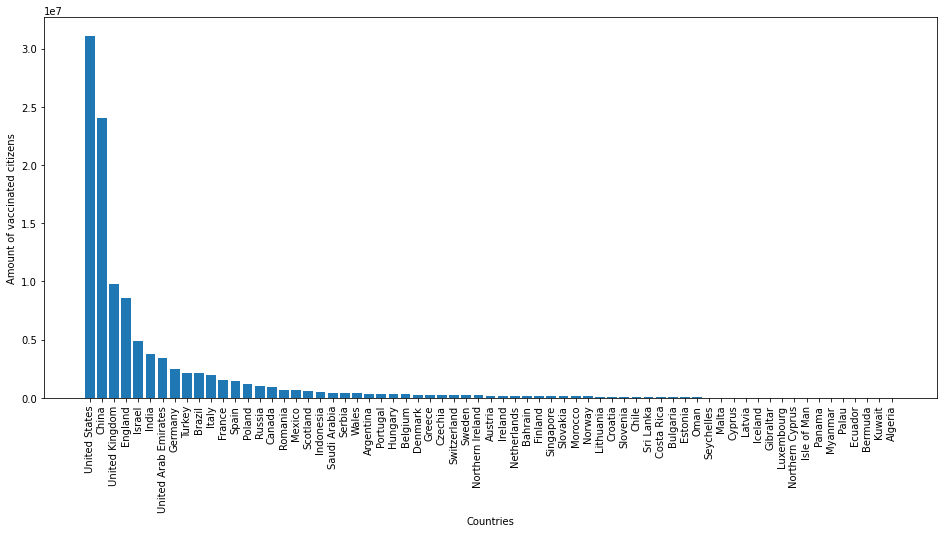

In [ ]:
cols = ['country', 'total_vaccinations', 'iso_code', 'vaccines', 'total_vaccinations_per_hundred']
vaccine_amount = data[cols].groupby('country').max().sort_values('total_vaccinations', ascending = False)
plt.figure(figsize=(16,7))
plt.bar(vaccine_amount.index, vaccine_amount.total_vaccinations)
plt.xticks(rotation = 90)
plt.ylabel('Amount of vaccinated citizens')
plt.xlabel('Countries')
plt.show()

The plot shows that the United States has received the most vaccines, with China not too far behind. There is a sharp drop off after this. We will now plot this information on a map. 

In [ ]:
fig = px.choropleth(locations=vaccine_amount.iso_code, color=vaccine_amount.total_vaccinations, title='Amount of vaccinated citizens', color_continuous_scale='rainbow')
fig.show()

The map shows many European countries as well as countries in South America, and Arabic countries are among the lowest amount of total vaccinated citizens. Interesting to note again that the UK having quite a lot of total vaccines, and then on the contrary, very large countries like Russia having very little total vaccinations. We will not look at the total vaccinations per hundred to get a more accurate picture of country's access to the vaccine
 

# Amount Vaccinated Per Hundred


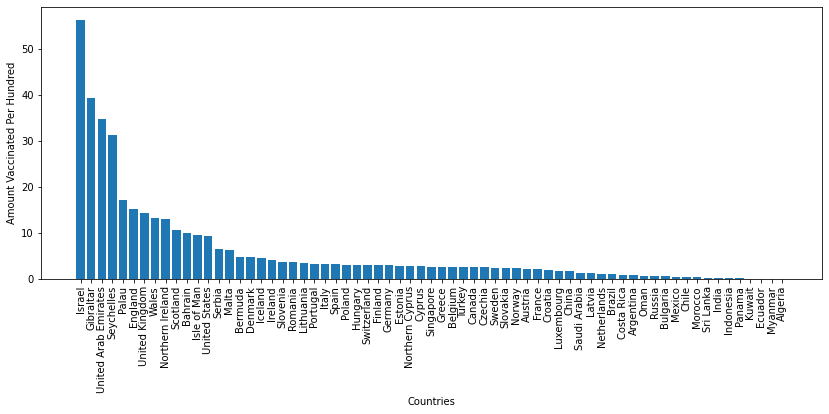

In [ ]:
vaccine_amount = vaccine_amount.sort_values('total_vaccinations_per_hundred', ascending = False)
plt.figure(figsize=(14,5))
plt.bar(vaccine_amount.index, vaccine_amount.total_vaccinations_per_hundred)
plt.xticks(rotation = 90)
plt.ylabel('Amount Vaccinated Per Hundred')
plt.xlabel('Countries')
plt.show()

Israel, Gibraltar and UAE are the three countries with the highest levels of vaccinated people per hundred. It should be noted that these countries do not have high populations and hence the high statistic. The UK is quite high up the list for a country its size and is a far bigger country than the countries ahead of it. We will now plot this data on a map

In [ ]:
fig = px.choropleth(locations=vaccine_amount.iso_code, color = vaccine_amount.total_vaccinations_per_hundred, title = 'Amount of Vaccinated Citizens per Hundred')
fig.show()

USA's vaccination level per hundred people is also on the higher end. Asia, Russia and South America all among the lowest level.

# Most Popular Vaccine

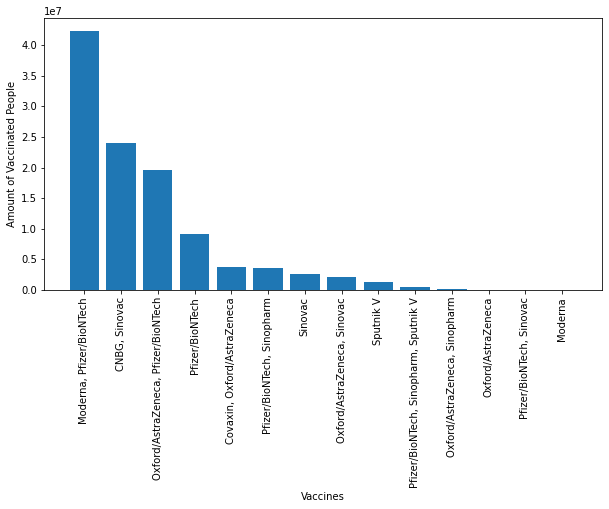

In [ ]:
vaccine_pop = vaccine_amount.groupby('vaccines').sum().sort_values('total_vaccinations', ascending = False)
plt.figure(figsize=(10,5))
plt.bar(vaccine_pop.index, vaccine_pop.total_vaccinations)
plt.xticks(rotation = 90)
plt.ylabel('Amount of Vaccinated People')
plt.xlabel('Vaccines')
plt.show()

Pfizer/BioNTech appears to be the most popular and most widespread vaccine. We will show this data on a map.

In [ ]:
fig = px.choropleth(locations=vaccine_amount.iso_code, color=vaccine_amount.vaccines, title='Name of the vaccine', 
                   color_continuous_scale='rainbow')
fig.show()

# Vaccination Amount Prediction

In [ ]:
t_cols = ['date', 'total_vaccinations']
timeseries_cov = data[t_cols].groupby('date').sum()[4:-1]

def invboxcox(y, l):
  if l == 0:
    return np.exp(y)
  else:
    return np.exp(np.log(l*y+1)/1)
    

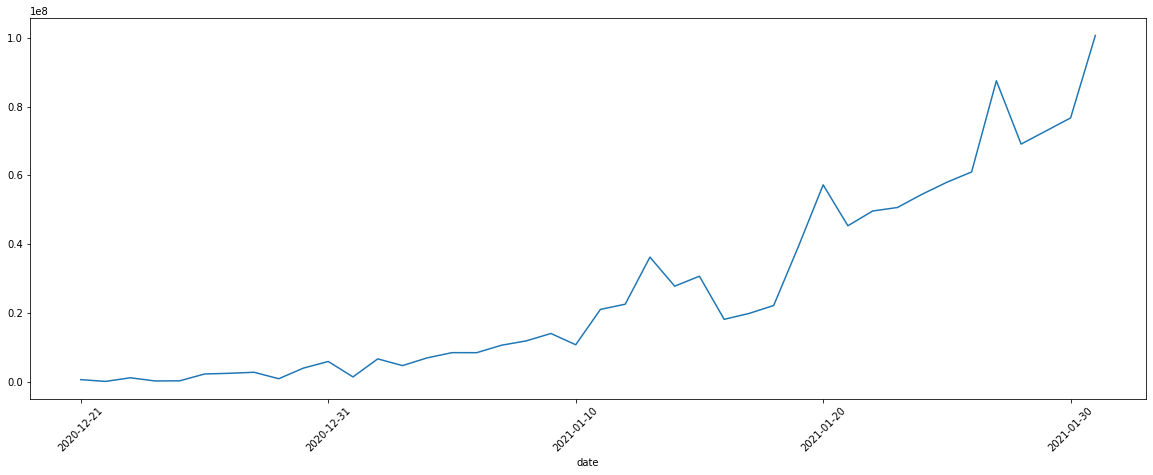

In [ ]:
plt.figure(figsize=(20,7))
timeseries_cov.total_vaccinations.plot()
plt.xticks(rotation = 45)
plt.show()

A strong uptrend in the amount of people getting the vaccine despite there being some dips some of the days.
However to make future predictions of these values, the above timeseries must be stationary.
